In [15]:
# ! pip install tqdm
# !pip install pandas
# !pip install --upgrade pip
# !pip install numpy
# !pip install matplotlib
# ! pip install seaborn
# !pip install sklearn torch pytorch_lightning pytorch_forecasting

  Preparing metadata (setup.py) ... done


In [3]:
from tqdm.notebook import tqdm as tqdm

import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import numpy as np
import matplotlib.pylab as plt
import seaborn as sns

import warnings
warnings.filterwarnings('ignore')


from sklearn.preprocessing import MinMaxScaler

import torch
import pytorch_lightning as pl
from pytorch_lightning.loggers import TensorBoardLogger
from pytorch_lightning.callbacks import EarlyStopping, LearningRateMonitor


logger = TensorBoardLogger("lightning_log", name="deepAR")

from pytorch_forecasting import Baseline, DeepAR, TimeSeriesDataSet
from pytorch_forecasting.data import NaNLabelEncoder
from pytorch_forecasting.metrics import SMAPE, MultivariateNormalDistributionLoss

In [4]:
max_encoder_length = 60
max_prediction_length = 20

In [12]:
training = TimeSeriesDataSet.load('training_timeseriesdataset.tsd')
validation = TimeSeriesDataSet.load('validation_timeseriesdataset.tsd')
batch_size = 128
train_dataloader = training.to_dataloader(train = True, batch_size = batch_size, num_workers = 0)
val_dataloader = validation.to_dataloader(train = False, batch_size = batch_size, num_workers = 0)

### Calculate baseline errror

In [5]:
# actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
# baseline_predictions = Baseline().predict(val_dataloader)
# SMAPE()(baseline_predictions, actuals)
#tensor(0.4668)


### Define model

In [8]:
pl.seed_everything(42)

net = DeepAR.from_dataset(
    training, 
    learning_rate = 1e-3, 
    hidden_size = 128, 
    rnn_layers = 3, 
   loss = MultivariateNormalDistributionLoss()
)

Global seed set to 42


In [27]:
best_model = net.load_from_checkpoint('/home/kyle/tmp_lecture/jeon-test/lightning_log/deepAR/version_30/checkpoints/epoch=255-step=7680.ckpt')
actuals = torch.cat([y[0] for x, y in iter(val_dataloader)])
predictions = best_model.predict(val_dataloader)
SMAPE()(actuals, predictions)

FileNotFoundError: [Errno 2] No such file or directory: '/home/kyle/tmp_lecture/jeon-test/lightning_log/deepAR/version_30/checkpoints/epoch=255-step=7680.ckpt'

In [ ]:
print(best_model)

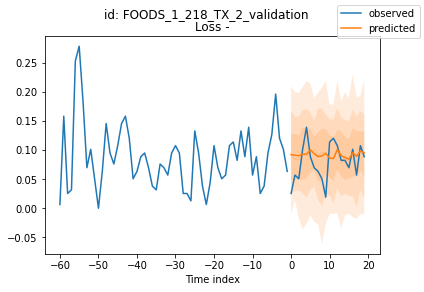

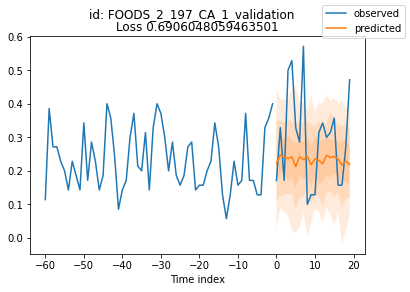

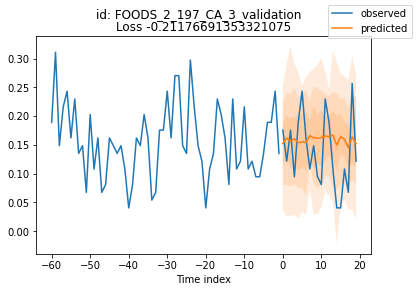

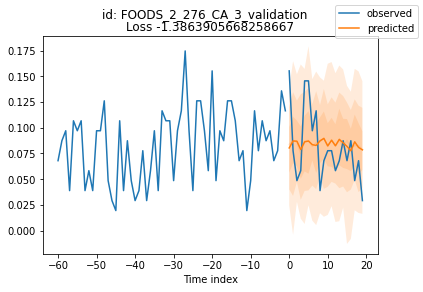

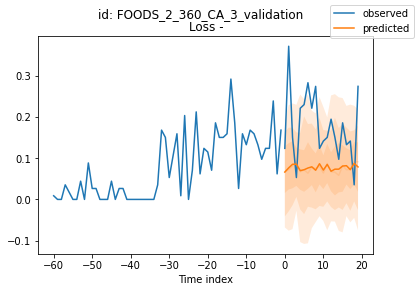

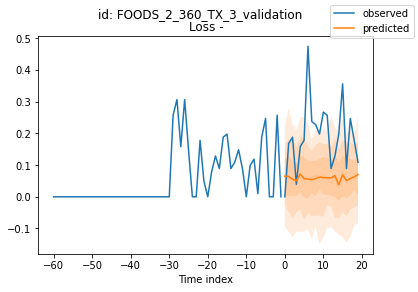

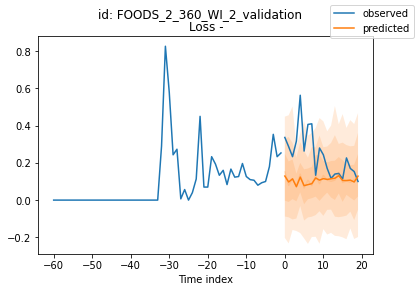

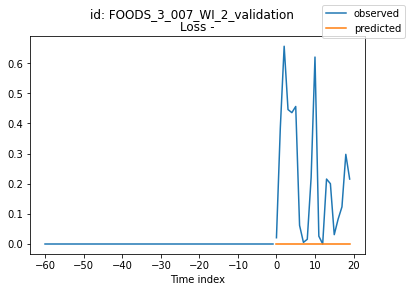

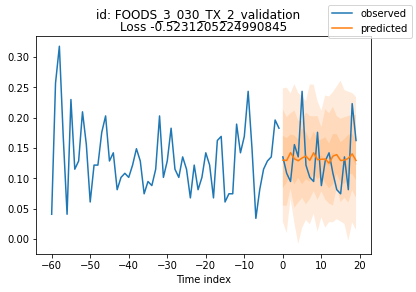

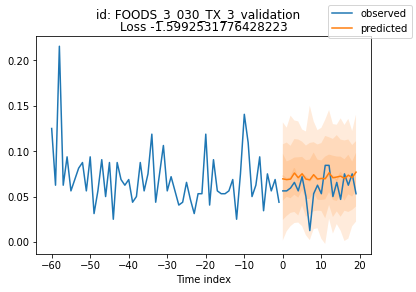

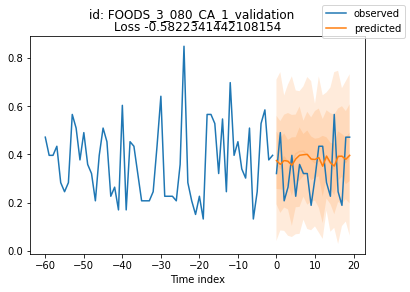

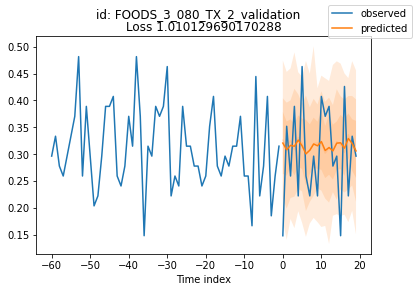

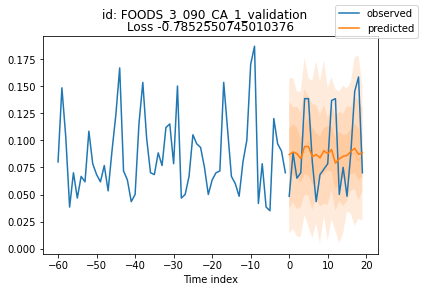

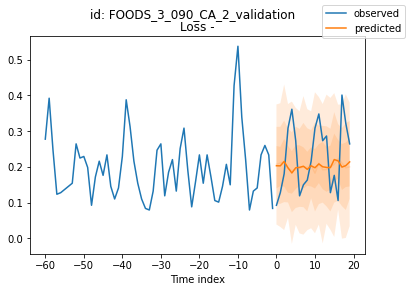

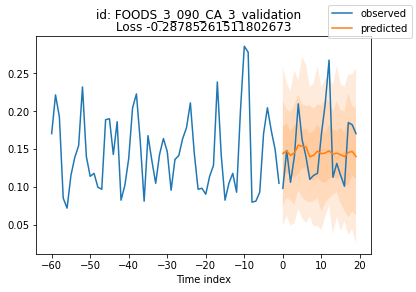

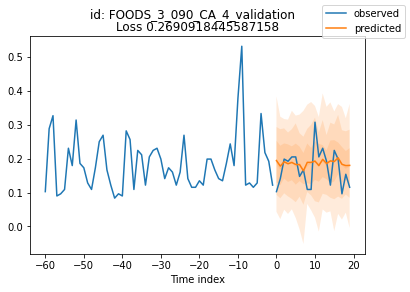

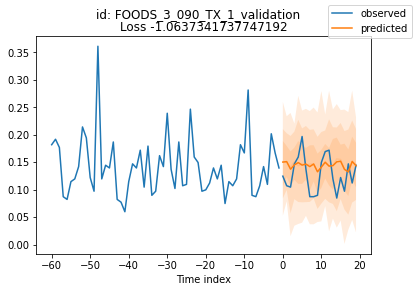

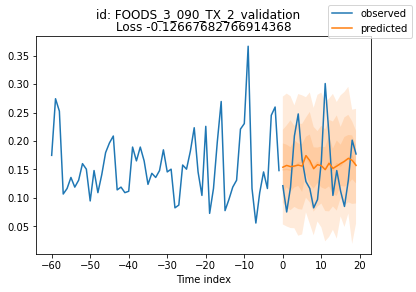

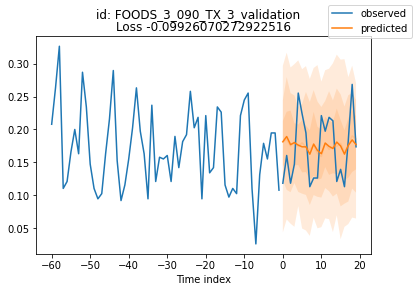

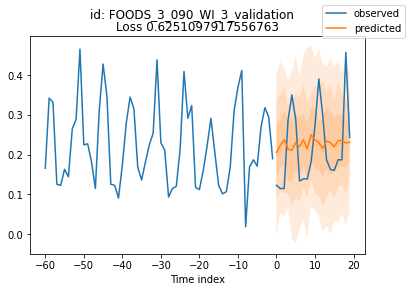

In [24]:
raw_predictions, x = net.predict(val_dataloader, mode = 'raw', return_x=True, n_samples=100)
series = validation.x_to_index(x)["id"]
for idx in np.arange(0, 20):  # plot 10 examples
    best_model.plot_prediction(x, raw_predictions, idx=idx, add_loss_to_title=True)
    plt.suptitle(f"id: {series.iloc[idx]}")